### Note:
This notebook is used to estimate the joint angle through the EMG signal

In [1]:
import os
import glob
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import imageio

import pandas as pd

%matplotlib inline

### Data preprocessing

In [4]:
# For load estimation

# path = r'/home/jerry/GitHub/EMG_regressive_model/train_data/2'
path = r'D:\GitHub\EMG_regressive_model\ann\train_data\2'
all_files = glob.glob(path + "/*csv")
dfList = []

for filename in all_files:
    df = pd.read_csv(filename)
    df.head()
    dfList.append(df)
frame = pd.concat(dfList, axis = 1, ignore_index = False)
frame.head()

,ch 1,ch 2,ch 3,ch 4,ch 5,ch 6,ch 7,ch 8,ch 9,ch 10,ch 11,ch 12,ch 13,ch 14,ch 15,angle
0,0.017648,0.000315,0.000315,0.017640,7.067573e-17,0.175230,0.030838,0.030838,0.175326,0.000220,0.094976,0.009046,0.009046,0.094906,1.558396e-19,0.007801
1,0.016601,0.000279,0.000279,0.016591,6.507132e-17,0.150075,0.022609,0.022609,0.150071,0.000161,0.080666,0.006525,0.006525,0.080570,7.776342e-20,0.007804
2,0.016045,0.000261,0.000261,0.016034,6.218418e-17,0.137214,0.018890,0.018890,0.137146,0.000136,0.072566,0.005277,0.005277,0.072434,5.224302e-20,0.007807
3,0.015644,0.000248,0.000248,0.015633,6.013456e-17,0.134190,0.018065,0.018065,0.134110,0.000131,0.071210,0.005081,0.005081,0.071071,4.885590e-20,0.007811
4,0.015258,0.000236,0.000236,0.015247,5.819516e-17,0.136297,0.018637,0.018637,0.136219,0.000135,0.074915,0.005624,0.005624,0.074782,5.865443e-20,0.007815


In [5]:
# create input and output data
x = frame.iloc[:, 0:-1]
y = frame.iloc[:, -1]

# split the data into train, validate, and test set
# because there is a class imblance, should use the stratify opton to make each set has identical distribution
X_trainval, X_test, y_trainval, y_test = train_test_split(x, y)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1)

In [6]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [7]:
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

### Setup the Neural Network

In [8]:
#Reproducible
torch.manual_seed(1)

### Check whether the GPU is available

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
class RegressionDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return len(self.x_data)

In [12]:
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(),
                                 torch.from_numpy(y_train).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(),
                                torch.from_numpy(y_test).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(),
                               torch.from_numpy(y_val).float())


### Build the feedforward neural network

In [17]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        self.fc1 = nn.Linear(num_features, 64)
        self.fc2 = nn.Linear(64, 128)
#         self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(128, 1)
        
        self.act = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, inputs):
        x = self.act(self.fc1(inputs))
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.output(x)
        return x
    
    def predict(self, test_inputs):
        x = self.act(self.fc1(test_inputs))
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.output(x)
        
        return x
        
        

In [18]:
EPOCHS = 50
BATCH_SIZE = 1
LEARNING_RATE = 0.001
NUM_FEATURES = len(x.columns)

In [19]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [20]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)

print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

MultipleRegression(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
  (act): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [21]:
# Define a dictionary which will store the loss / epoch for both train and validation sets
loss_stats = {
    'train':[],
    'val':[]
}

### Train the network

In [ ]:
print('=========Begin Training=========')
for e in range(1, EPOCHS+1):
    
    #TRAINING
    train_epoch_loss = 0
    model.train()
    
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
    
    #VALIDATION
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
            
    loss_stats['train'].append(train_epoch_loss / len(train_loader))
    loss_stats['val'].append(val_epoch_loss / len(val_loader))
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Validation Loss: {val_epoch_loss/len(val_loader):.5f}')
    
    

=========Begin Training=========
Epoch 001: | Train Loss: 0.15402 | Validation Loss: 0.16067
Epoch 002: | Train Loss: 0.14119 | Validation Loss: 0.16911
Epoch 003: | Train Loss: 0.13664 | Validation Loss: 0.12630
Epoch 004: | Train Loss: 0.13278 | Validation Loss: 0.12845
Epoch 005: | Train Loss: 0.13086 | Validation Loss: 0.12718
Epoch 006: | Train Loss: 0.12917 | Validation Loss: 0.12933
Epoch 007: | Train Loss: 0.12847 | Validation Loss: 0.12716
Epoch 008: | Train Loss: 0.12740 | Validation Loss: 0.12244
Epoch 009: | Train Loss: 0.12673 | Validation Loss: 0.12052
Epoch 010: | Train Loss: 0.12355 | Validation Loss: 0.12242
Epoch 011: | Train Loss: 0.12151 | Validation Loss: 0.12542
Epoch 012: | Train Loss: 0.12159 | Validation Loss: 0.12428
Epoch 013: | Train Loss: 0.12133 | Validation Loss: 0.11468
Epoch 014: | Train Loss: 0.11845 | Validation Loss: 0.11473
Epoch 015: | Train Loss: 0.12198 | Validation Loss: 0.12013
Epoch 016: | Train Loss: 0.11997 | Validation Loss: 0.12311
Epoch 0

### Post processing
1. Vsiualize loss and accuracy
2. Test trained model

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

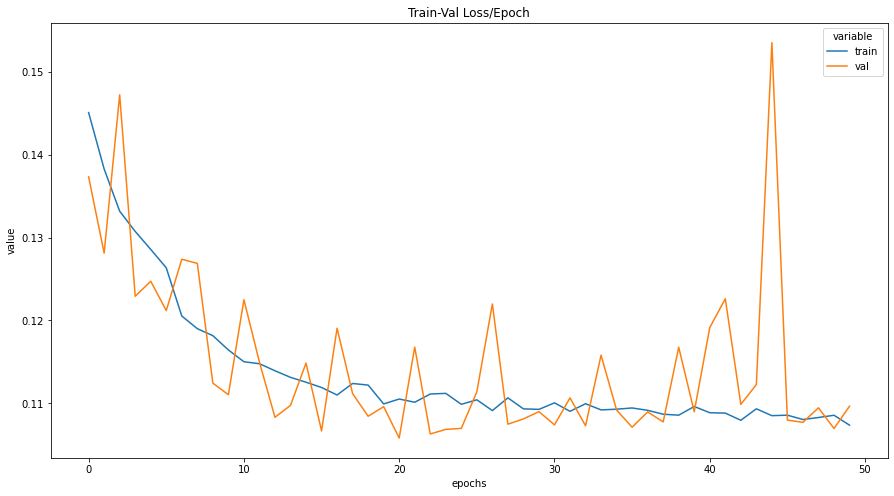

In [65]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [66]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())

In [67]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

### Batch = 1, Epoches = 1000

In [68]:
mse = mean_squared_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)

print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 0.11477606725625061
R^2 : 0.21814162699884354


### Comments:
    By observing the MSE and R^2 for the test set, the trained model is acceptable for one set of data. However, the validation losee still fluctuates as previous trial. Also, overfit problem exists in the training process. Therefore, drop out method should be added to the neural netwrok architecture. For validation, we can use K-fold validation to replace current validation method.
    Next step should test the model with data collect from different session.